In [1]:
%store -r unlabeled_normalized_df

In [2]:
unlabeled_normalized_df.head()

,x,x2,x3,y,y2
3,0.371371,0.371371,0.371371,0.896552,0.896552
4,0.329507,0.329507,0.329507,0.827586,0.827586
6,0.183660,0.183660,0.183660,0.034483,0.034483
7,0.132343,0.132343,0.132343,0.241379,0.241379
8,0.926401,0.926401,0.926401,0.896552,0.896552


In [4]:
import sagemaker
from sagemaker import get_execution_role

session = sagemaker.Session()
role = get_execution_role()
bucket = session.default_bucket()

In [7]:
from sagemaker import KMeans

estimator = KMeans(
    role=role,
    instance_count=1,
    instance_type='ml.c4.xlarge',
    k=2)

In [6]:
data_np = unlabeled_normalized_df.values.astype('float32')
record_set = kmeans.record_set(data_np)

In [8]:
estimator.fit(record_set)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-04-18 08:02:17 Starting - Starting the training job...
2021-04-18 08:02:18 Starting - Launching requested ML instancesProfilerReport-1618732936: InProgress
......
2021-04-18 08:03:44 Starting - Preparing the instances for training.........
2021-04-18 08:05:10 Downloading - Downloading input data...
2021-04-18 08:05:44 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/18/2021 08:05:55 INFO 140342932858240] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_k


2021-04-18 08:06:05 Uploading - Uploading generated training model
2021-04-18 08:06:05 Completed - Training job completed
Training seconds: 55
Billable seconds: 55


In [9]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-------------------!

In [10]:
results = predictor.predict(data_np)
results

[label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 0.0
     }
   }
 }
 label {
   key: "distance_to_cluster"
   value {
     float32_tensor {
       values: 0.6046929359436035
     }
   }
 },
 label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 0.0
     }
   }
 }
 label {
   key: "distance_to_cluster"
   value {
     float32_tensor {
       values: 0.6579821109771729
     }
   }
 },
 label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 1.0
     }
   }
 }
 label {
   key: "distance_to_cluster"
   value {
     float32_tensor {
       values: 0.2311795949935913
     }
   }
 },
 label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 1.0
     }
   }
 }
 label {
   key: "distance_to_cluster"
   value {
     float32_tensor {
       values: 0.1673380583524704
     }
   }
 },
 label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 0.0
     }
   }
 }
 l

In [11]:
def extract_values(item):
    closest_cluster = item.label['closest_cluster']
    cc_value = int(closest_cluster.float32_tensor.values[0])
    distance_to_cluster = item.label['distance_to_cluster']
    dtc_value = distance_to_cluster.float32_tensor.values[0]
    
    return {
        "closest_cluster": cc_value,
        "distance_to_cluster": dtc_value
    }

In [12]:
extract_values(results[0])

{'closest_cluster': 0, 'distance_to_cluster': 0.6046929359436035}

In [13]:
closest_cluster_list = []
distance_to_cluster_list = []

for result in results:
    cluster_values = extract_values(result)
    closest_cluster_list.append(cluster_values["closest_cluster"])
    distance_to_cluster_list.append(cluster_values["distance_to_cluster"])

In [14]:
closest_cluster_list[0:6]

[0, 0, 1, 1, 0, 1]

In [15]:
df = unlabeled_normalized_df
df = df.assign(closest_cluster=closest_cluster_list)
df = df.assign(distance_to_cluster=distance_to_cluster_list)
df.head()

,x,x2,x3,y,y2,closest_cluster,distance_to_cluster
3,0.371371,0.371371,0.371371,0.896552,0.896552,0,0.604693
4,0.329507,0.329507,0.329507,0.827586,0.827586,0,0.657982
6,0.183660,0.183660,0.183660,0.034483,0.034483,1,0.231180
7,0.132343,0.132343,0.132343,0.241379,0.241379,1,0.167338
8,0.926401,0.926401,0.926401,0.896552,0.896552,0,0.412965


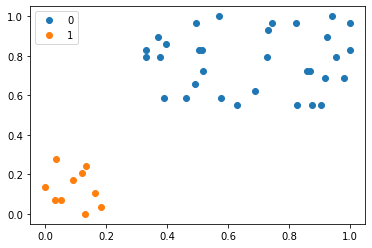

In [16]:
import matplotlib.pyplot as plt

groups = df.groupby("closest_cluster")

for name, group in groups:
    plt.plot(group["x"], group["y"], marker="o", linestyle="", label=name)
    
plt.legend()